# **PROYECTO 4 -   Sistema de Recomendaciones Steam+Ampliación de Sentiment Analisis con NLP** 
**Este proyecto se monta sobre el trabajo Nro. 3 y pretende,después de realizar la combinación de los datasets, ampliar el análisis exploratorio de la columna "Text" a fin de determinar si existe la posibilidad de mejorar las predicciones: hasta el momento se recomendaron solo los juegos cuyos reviews fueron relizados por usuarios que jugaron más de su mediana global de horas de juego, dejando fuera a aquellos con comentarios positivos por debajo de dicho nivel y a los juegos con comentarios positivos con "hours" por encima de dicho nivel.**

**El análisis se llevará a cabo en el apartado "Parte D - Análisis Exploratorio usando NLP"**

**A continuación, el link al repositorio GitHub: https://github.com/agueroaugusto/steam/(se cargó solo el dataset Games ya que el de Reviews excede los 25mb y se acotó el Grid Search de los modelos vistos en tp3 para optimizar la demora)**

## **Parte A - Análisis Exploratorio**

In [1]:
#Librerías 
import gzip
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc #garbage collector
#from pandas_profiling import ProfileReport
import itertools
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\augusto\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\augusto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Reviews

#Se inicia abriendo el archivo json y pasandolo a csv.
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)
contador = 0
data_reviews = []
n = 1
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1
reviews = pd.DataFrame(data_reviews)

#se guarda el dataset 
reviews.to_csv('reviews.csv', index= False)

In [2]:
#se carga el dataset modificado y se imrimen las primeras instancias
reviews = pd.read_csv(r'reviews.csv')
#evitamos que los product_id aparezcan con notación cientrífica
pd.options.display.float_format = '{:.1f}'.format
#borramos duplicados
reviews.drop_duplicates(subset=['product_id', 'user_id'], keep='last')
#imprimimos las primeras instancias
reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,nan,NaN,nan
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,nan,NaN,nan
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,nan
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,nan,NaN,nan
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,nan,NaN,76561198007483072.0


In [3]:
reviews.describe()

,hours,products,product_id,page_order,page,found_funny,user_id
count,7766532.0,7778108.0,7793069.0,7793069.0,7793069.0,1200756.0,3176223.0
mean,111.8,236.5,251380.5,4.5,893.0,7.9,76561198096417120.0
std,392.9,485.8,150112.0,2.9,1927.7,73.4,100841037.5
min,0.0,1.0,10.0,0.0,1.0,1.0,76561197960265808.0
25%,4.0,45.0,203770.0,2.0,52.0,1.0,76561198025640032.0
50%,15.3,110.0,252490.0,4.0,237.0,1.0,76561198071083136.0
75%,59.7,246.0,346110.0,7.0,829.0,3.0,76561198140793520.0
max,42100.7,18188.0,777950.0,9.0,18371.0,13318.0,76561198803033792.0


**Features (con una breve descripción de los datos según Profile Report)**
- *username*: nombre del usuario, el 17.6% de los valores son únicos.
- *hours*: cantidad de horas jugadas al realizar el comentario.  Median=15.3 < Mean=111.8364833. La distribución tiene cola hacia la derecha.
- *products*: cantidad de productos adquiridos al realizar el comentario. median	110 < Mean	236.4839008.  La distribución tiene cola hacia la derecha.
- *product_id*: identificación del producto. hay 15474 juegos con comentarios.
- *page_order*: posición del comentario dentro de la página (cada juego tiene páginas de comentarios).  sus valores oscilan entre 1 y 10 y tiene una distribución uniforme. Esta columna no nos arroja información.-    
- *date*: fecha del comentario.  durante el mes de noviembre de los años 2016 y 2017 parecieran estar los picos.
- *text*: comentario. el valor más común es 'good game' y, al igual que todos los valores más frecuentes, indican valoraciones positivas.
- *early_access*: true si corresponde a un juego con acceso temprano.  el 13.8% de los reviews se realizaron sobre juegos con acceso temprano.
- *page*: página de comentario del juego. Median=237, Mean=893.0330963 (cada página tiene diez comentarios). Nuevamente se observa una cola hacia la derecha.
- *user_id*: id del usuario.  Hay 1426419 usuarios que realizaron comentarios
- *found_funny*: cantidad de usuarios para los que la review resultó divertida. el valor máximo es 13218. No sabemos para qué usuarios resultó divertido por lo que no podremos extrapolar el review.
- *compensation*: pago por juego. Product received for free =1,8%, el resto son missing. Esta columna no nos arroja información.

### **Missing Values**

C:\Users\augusto\anaconda3\envs\data_science\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


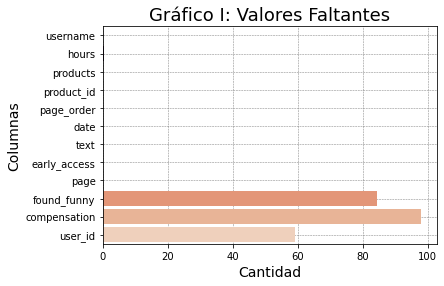

,Total,Percent
compensation,7647446,98.1
found_funny,6592313,84.6
user_id,4616846,59.2
hours,26537,0.3
text,17972,0.2
products,14961,0.2
username,208,nan


In [4]:
#Valores faltantes
missing=reviews.isna().sum()/len(reviews)*100
#se crea otra serie para usar como variable independiente.
columnas=reviews.columns
##Gráfico
sns.barplot(y=columnas, x = missing, palette="rocket")
plt.title("Gráfico I: Valores Faltantes",fontsize=18)
plt.xlabel("Cantidad",fontsize=14)
plt.ylabel("Columnas",fontsize=14)
ax = plt.axes()
plt.grid(True,color='grey', linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)
plt.show()
def missing_percentage(df):
    total = reviews.isnull().sum().sort_values(ascending = False)[reviews.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(reviews.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(reviews.isnull().sum().sort_values(ascending = False)/len(reviews)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])
missing_percentage(reviews)

**Se descartarán found_funny y compensation. El principal problema del dataset es que cuenta con casi el 60% de valores faltantes en los id de los usuarios. También se eliminarpa page_order por no aportar información significativa.**

### **Descarte de columnas poco significativas+optimización de tipo de datos**

In [5]:
#se reorganiza el dataset tomando solo las columnas relevantes
reviews=reviews[['user_id','username','product_id','text','hours','products','date','page','early_access']]
#se eliminan los valores faltantes
#no se eliminan para user_id porque son demasiados
reviews.dropna(subset=['username'], how='all', inplace=True)
reviews.dropna(subset=['text'], how='all', inplace=True)
reviews.dropna(subset=['hours'], how='all', inplace=True)
reviews.dropna(subset=['products'], how='all', inplace=True)
#impresión de tipo de datos

#se optimizan los datatypes
reviews['product_id'] = reviews['product_id'].astype(np.uint32)
reviews['hours'] = reviews['hours'].astype(np.float16)
reviews['products'] = reviews['products'].astype(np.uint16)
reviews['page'] = reviews['page'].astype(np.uint16)
#reviews['user_id'] = reviews['user_id'].astype(np.int64)
#se guarda el dataset
#reviews.to_csv('reviews_opt.csv', index= False)
print(reviews.dtypes)
reviews.head()

user_id         float64
username         object
product_id       uint32
text             object
hours           float16
products         uint16
date             object
page             uint16
early_access       bool
dtype: object


,user_id,username,product_id,text,hours,products,date,page,early_access
0,nan,Chaos Syren,725280,This would not be acceptable as an entertainme...,0.1,41,2017-12-17,1,False
1,nan,₮ʜᴇ Wᴀʀᴛᴏɴ,328100,looks like a facebook game,51.1,769,2017-12-27,1,False
2,nan,hello?<,328100,Better than Minecraft,14.6,2,2017-10-16,1,False
3,nan,Cyderine916,35140,I love and idolized Batman and this game is Ma...,5.0,64,2018-01-04,1,False
4,76561198007483072.0,DarklyThinking,35140,Still worth playing in 2018.\nProbably my favo...,16.6,577,2018-01-04,1,False


### **Preguntas sobre Reviews**

### 1- Dado que existen un 60% de missing_values para  user_id, podemos reemplazar esta columna con el nombre de los usuarios?

C:\Users\augusto\anaconda3\envs\data_science\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 3640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\augusto\anaconda3\envs\data_science\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 3640 missing from current font.
  font.set_text(s, 0, flags=flags)


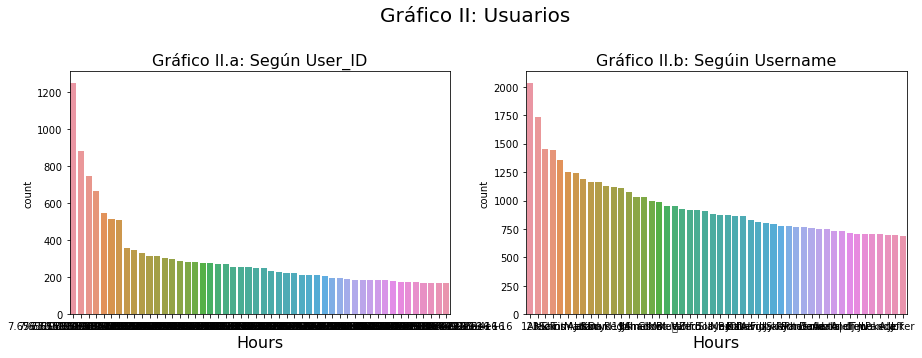

,user_id,username,product_id,text,hours,products,date,page,early_access
29045,76561198021444240.0,123,1610,One of the best space games ive ever played,97.9,103,2014-02-02,9,False
29510,76561198072738320.0,123,271590,"Don't buy. They don't bother fixing bugs, only...",484.0,69,2017-12-30,107,False
47279,76561198141516112.0,123,427730,the game is boring without freinds but with th...,7.9,19,2016-12-29,205,False
49267,76561198120382960.0,123,35140,"Great game, with a good story. Lots to explore...",4.6,243,2016-06-30,242,False
51651,76561198194763872.0,123,350280,I enjoy games again.,68.5,145,2017-08-14,239,False


In [6]:
#Boxplot Rooms
fig=plt.figure(figsize=(15,5))
plt.suptitle('Gráfico II: Usuarios',fontsize=20, ha='center')
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
sns.countplot(reviews['user_id'], ax=ax1,order=reviews.user_id.value_counts().iloc[:50].index)

sns.countplot(reviews['username'], ax=ax2,order=reviews.username.value_counts().iloc[:50].index)
ax1.set_title("Gráfico II.a: Según User_ID",fontsize=16)
ax2.set_title("Gráfico II.b: Segúin Username",fontsize=16)
ax1.set_xlabel('Hours',fontsize=16)
#ax1.set_ylabel('Rooms',fontsize=16)
ax2.set_xlabel('Hours',fontsize=16)
#ax2.set_ylabel('Rooms',fontsize=16)
fig.subplots_adjust(top=0.8)
plt.show()

user=reviews[(reviews.username=='123')]
user.head()

**Hay muchos user id que se loguean con diferentes usernames, por lo que no podremos recurrir al nombre para utilizarlos.**

### 2- ¿Cuáles son los juegos más comentados?

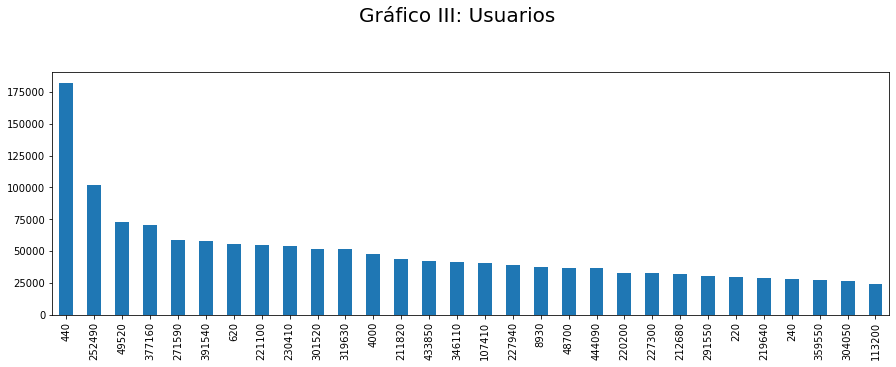

In [7]:

fig=plt.figure(figsize=(15,5))
plt.suptitle('Gráfico III: Usuarios',fontsize=20, ha='center')
reviews['product_id'].value_counts().iloc[:30].plot(kind='bar')
reviews['product_id'].value_counts().iloc[:5]
fig.subplots_adjust(top=0.8)
plt.show()


**Los juegos más comentados son el 440, el 52490 y el 49520, cuando analicemoso el siguiente dataset sabremos de qué juegos se trata.**

## 3- ¿Cuántas horas  juega cada usuario?

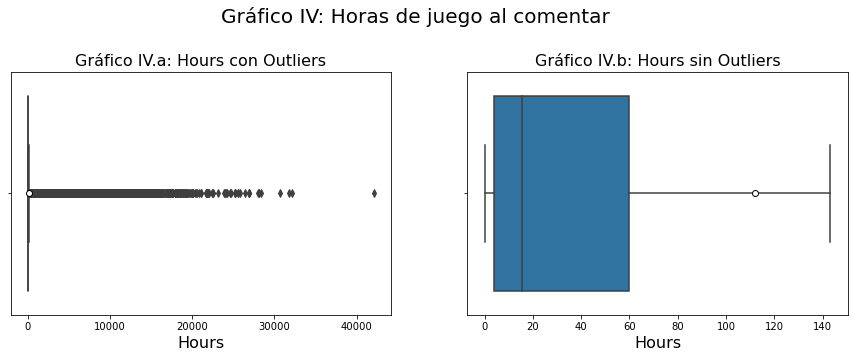

count   7733533.0
mean          nan
std           nan
min           0.0
25%           4.0
50%          15.4
75%          59.7
max       42112.0
Name: hours, dtype: float64

In [8]:
#Boxplot Rooms
fig=plt.figure(figsize=(15,5))
plt.suptitle('Gráfico IV: Horas de juego al comentar',fontsize=20, ha='center')
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
sns.boxplot(data = reviews,x='hours',showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax1)

sns.boxplot(data = reviews,x='hours',showfliers=False,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax2)
ax1.set_title("Gráfico IV.a: Hours con Outliers",fontsize=16)
ax2.set_title("Gráfico IV.b: Hours sin Outliers",fontsize=16)
ax1.set_xlabel('Hours',fontsize=16)
#ax1.set_ylabel('Rooms',fontsize=16)
ax2.set_xlabel('Hours',fontsize=16)
#ax2.set_ylabel('Rooms',fontsize=16)
fig.subplots_adjust(top=0.8)
plt.show()

reviews.hours.describe()

**La mediana indica que los usuarios jugaron 15.4 horas a la hora de realizar los comentarios. Este valor puede resultar más representativo que el promedio dado que la distribución tiene una marcada cola hacia la derecha.**

### 4- Cuántos juegos tiene cada usuario?

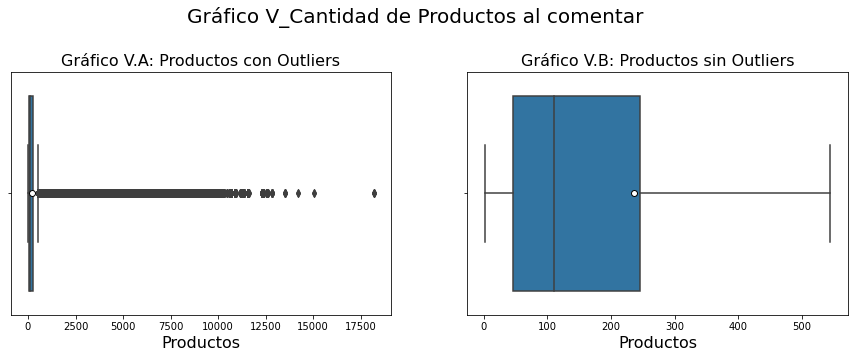

count   7733533.0
mean        235.4
std         483.7
min           1.0
25%          45.0
50%         110.0
75%         245.0
max       18188.0
Name: products, dtype: float64

In [9]:
#Boxplot Rooms
fig=plt.figure(figsize=(15,5))
plt.suptitle('Gráfico V_Cantidad de Productos al comentar',fontsize=20, ha='center')
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
sns.boxplot(data = reviews,x='products',showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax1)
sns.boxplot(data = reviews,x='products',showfliers=False,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax2)
ax1.set_title("Gráfico V.A: Productos con Outliers",fontsize=16)
ax2.set_title("Gráfico V.B: Productos sin Outliers",fontsize=16)
ax1.set_xlabel('Productos',fontsize=16)
#ax1.set_ylabel('Rooms',fontsize=16)
ax2.set_xlabel('Productos',fontsize=16)
#ax2.set_ylabel('Rooms',fontsize=16)
fig.subplots_adjust(top=0.8)
plt.show()

reviews.products.describe()

**En promedio, cada usuario tiene 235 juegos. La mediana es 110.**

### 6- Cuándo se realizaron los comentarios?.

2018-01-05
2010-10-15


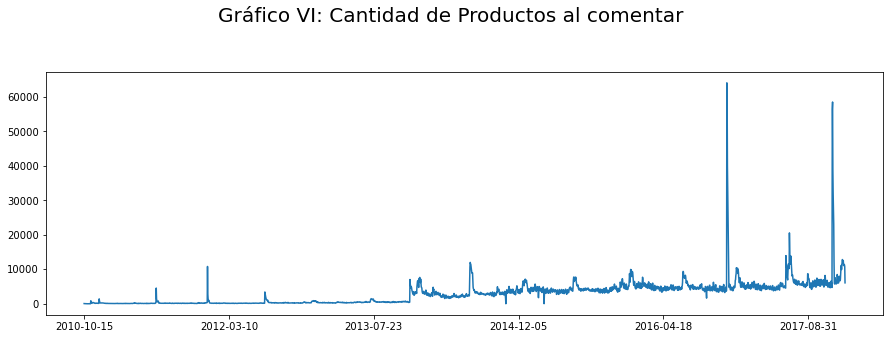

count   7733533.0
mean        235.4
std         483.7
min           1.0
25%          45.0
50%         110.0
75%         245.0
max       18188.0
Name: products, dtype: float64

In [10]:

print(reviews.date.max())
print(reviews.date.min())
#
fig=plt.figure(figsize=(15,5))
plt.suptitle('Gráfico VI: Cantidad de Productos al comentar',fontsize=20, ha='center')

reviews['date'].value_counts().sort_index().plot(kind='line', figsize=(15,5)) # ver layout
#ax2.set_ylabel('Rooms',fontsize=16)
fig.subplots_adjust(top=0.8)
plt.show()

reviews.products.describe()





**Los primeros comentarios son del 2010-10-15 y los últimos del 2018-01-05. El gráfico muestra que existe una tendencia al aumento en la cantidad de comentarios a media que pasa el tiempo.**

# Data_Games

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)
contador = 0
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
games = pd.DataFrame(data_games)

games.to_csv('games.csv', index= False)

In [11]:
#se carga el dataset modificado y se imrimen las primeras instancias
games = pd.read_csv(r'games.csv')
games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",4.5,http://steamcommunity.com/app/761140/reviews/?...,['Single-player'],4.99,False,761140.0,Kotoshiro,NaN,nan
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",nan,http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,nan
2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...",nan,http://steamcommunity.com/app/670290/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free to Play,False,670290.0,Poolians.com,Mostly Positive,nan
3,彼岸领域,"['Action', 'Adventure', 'Casual']",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"['Action', 'Adventure', 'Casual']",0.8,http://steamcommunity.com/app/767400/reviews/?...,['Single-player'],0.99,False,767400.0,彼岸领域,NaN,nan
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"['Action', 'Indie', 'Casual', 'Sports']",1.8,http://steamcommunity.com/app/773570/reviews/?...,"['Single-player', 'Full controller support', '...",2.99,False,773570.0,NaN,NaN,nan


In [12]:
#iniciamos el análisis exploratorio con un profile
#games_profile = ProfileReport(games,title="Pandas Profiling Report")
#games_profile
games.describe()

,discount_price,id,metascore
count,225.0,32133.0,2607.0
mean,11.9,451757.4,72.3
std,17.5,182714.0,10.8
min,0.5,10.0,20.0
25%,1.4,329280.0,66.0
50%,4.2,452060.0,74.0
75%,22.7,593400.0,80.0
max,140.0,2028850.0,96.0


**Features (con una breve descripción según Pandas Profile)**
- publisher: empresa que publicó el juego. Existen 8230 valores únicos.
- genres: género del juego. El más frecuente es acción.
- app_name: nombre del juego. Hay 32094.
- title: nombre del juego alt. Hay 30054. App_name es más informativa.
- url:página del juego (Steam).
- release_date: fecha de lanzamiento. La más frecuente es 2012-10-16. Ese día se lanzó la plataforma.
- tags: categorías. Es similar a genres.
- discount_price: descuento. Missing 99.3%
- reviews_url: página de los comentarios (Steam).
- specs:especificaciones.
- price: precio
- early_access':acceso tempano Solo lo tienen un 6%.
- id: id del juego. 32132
- developer: empresa que publicó.Hay 10992 valores únicosl
- sentiment: el valor más frecuente es míxto. Sin embargo, en general las valoraciones son positivas.
- metascore: valoración de Metatric*
*sitio web que recopila reseñas de álbumes de música, videojuegos, películas, programas de televisión, DVD y libros.

## **Missing Values**

C:\Users\augusto\anaconda3\envs\data_science\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


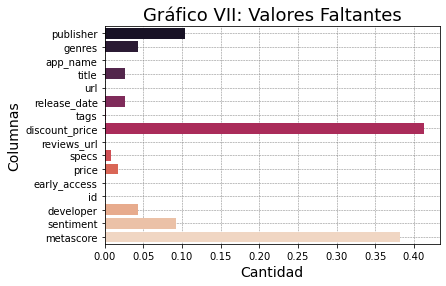

,Total,Percent
discount_price,31910,99.3
metascore,29528,91.9
publisher,8062,25.1
sentiment,7182,22.4
developer,3299,10.3
genres,3283,10.2
release_date,2067,6.4
title,2050,6.4
price,1377,4.3
specs,670,2.1


In [13]:
#Valores faltantes
missing=games.isna().sum()/len(reviews)*100
#se crea otra serie para usar como variable independiente.
columnas=games.columns

##Gráfico
sns.barplot(y=columnas, x = missing, palette="rocket")
plt.title("Gráfico VII: Valores Faltantes",fontsize=18)
plt.xlabel("Cantidad",fontsize=14)
plt.ylabel("Columnas",fontsize=14)
ax = plt.axes()
plt.grid(True,color='grey', linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)
plt.show()

def missing_percentage(df):
    total = games.isnull().sum().sort_values(ascending = False)[games.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(games.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(games.isnull().sum().sort_values(ascending = False)/len(games)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])
missing_percentage(games)

##  Selección de columnas relevantes

In [14]:
games=games[['id','app_name','title','developer','publisher','sentiment','release_date','genres','specs','tags','price']]
games.head()

,id,app_name,title,developer,publisher,sentiment,release_date,genres,specs,tags,price
0,761140.0,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro,Kotoshiro,NaN,2018-01-04,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",['Single-player'],"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",4.99
1,643980.0,Ironbound,Ironbound,Secret Level SRL,"Making Fun, Inc.",Mostly Positive,2018-01-04,"['Free to Play', 'Indie', 'RPG', 'Strategy']","['Single-player', 'Multi-player', 'Online Mult...","['Free to Play', 'Strategy', 'Indie', 'RPG', '...",Free To Play
2,670290.0,Real Pool 3D - Poolians,Real Pool 3D - Poolians,Poolians.com,Poolians.com,Mostly Positive,2017-07-24,"['Casual', 'Free to Play', 'Indie', 'Simulatio...","['Single-player', 'Multi-player', 'Online Mult...","['Free to Play', 'Simulation', 'Sports', 'Casu...",Free to Play
3,767400.0,弹炸人2222,弹炸人2222,彼岸领域,彼岸领域,NaN,2017-12-07,"['Action', 'Adventure', 'Casual']",['Single-player'],"['Action', 'Adventure', 'Casual']",0.99
4,773570.0,Log Challenge,NaN,NaN,NaN,NaN,NaN,NaN,"['Single-player', 'Full controller support', '...","['Action', 'Indie', 'Casual', 'Sports']",2.99


### 1-¿Cuántos juegos hay?

In [15]:
games.rename(columns={'id':'product_id'},inplace=True)
games.dropna(subset=['product_id'], how='all', inplace=True)
games['product_id'] = games['product_id'].astype(np.int32)


games.set_index('product_id',inplace=True)
print(games.shape)
games.head()

(32133, 10)


,app_name,title,developer,publisher,sentiment,release_date,genres,specs,tags,price
product_id,,,,,,,,,,
761140,Lost Summoner Kitty,Lost Summoner Kitty,Kotoshiro,Kotoshiro,NaN,2018-01-04,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",['Single-player'],"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",4.99
643980,Ironbound,Ironbound,Secret Level SRL,"Making Fun, Inc.",Mostly Positive,2018-01-04,"['Free to Play', 'Indie', 'RPG', 'Strategy']","['Single-player', 'Multi-player', 'Online Mult...","['Free to Play', 'Strategy', 'Indie', 'RPG', '...",Free To Play
670290,Real Pool 3D - Poolians,Real Pool 3D - Poolians,Poolians.com,Poolians.com,Mostly Positive,2017-07-24,"['Casual', 'Free to Play', 'Indie', 'Simulatio...","['Single-player', 'Multi-player', 'Online Mult...","['Free to Play', 'Simulation', 'Sports', 'Casu...",Free to Play
767400,弹炸人2222,弹炸人2222,彼岸领域,彼岸领域,NaN,2017-12-07,"['Action', 'Adventure', 'Casual']",['Single-player'],"['Action', 'Adventure', 'Casual']",0.99
773570,Log Challenge,NaN,NaN,NaN,NaN,NaN,NaN,"['Single-player', 'Full controller support', '...","['Action', 'Indie', 'Casual', 'Sports']",2.99


Hay 32133 juegos, mientras que en reviews hay 15474 con comentarios.

### 2- Es mejor trabajar con app_name y title?

In [16]:
app_name=games['app_name'].value_counts()
print('app_name:', app_name)

title=games['app_name'].value_counts()
print('titles: ', title)

#como se vio anteriormente, existen valores faltantes que serán completados
games['app_name'] = games['app_name'].fillna(games['title'])
games['title'] = games['title'].fillna(games['app_name'])

app_name: Soundtrack                                 3
WARZONE                                    2
Escape Room                                2
Streamline                                 2
The Fog                                    2
                                          ..
Magic: The Gathering - 2013 Deck Pack 3    1
Paintball 707                              1
FTC Workshop Tool                          1
GGXrd System Voice - POTEMKIN              1
Voice Splicer Plugin                       1
Name: app_name, Length: 32094, dtype: int64
titles:  Soundtrack                                 3
WARZONE                                    2
Escape Room                                2
Streamline                                 2
The Fog                                    2
                                          ..
Magic: The Gathering - 2013 Deck Pack 3    1
Paintball 707                              1
FTC Workshop Tool                          1
GGXrd System Voice - POTEMKIN        

**App name y title tienen la misma información, es mejor trabajar con app_name porque posee menos valores faltantes**

### 3 - Es mejor trabajar con developer o publisher?

In [17]:
games['developer'] = games['developer'].fillna(games['publisher'])
games['publisher'] = games['publisher'].fillna(games['developer'])

developers=games['developer'].value_counts()
print('developers: ', developers)

publishers=games['publisher'].value_counts()
print('publishers: ', publishers)

developers:  Ubisoft - San Francisco       1259
SmiteWorks USA, LLC            813
Dovetail Games                 253
KOEI TECMO GAMES CO., LTD.     232
Paradox Development Studio     156
                              ... 
Zadzen Games Ltd.                1
Manyland                         1
Timuz Games                      1
Back To Basics Gaming            1
Stegosoft Games                  1
Name: developer, Length: 11011, dtype: int64
publishers:  Ubisoft - San Francisco    1081
SmiteWorks USA, LLC         813
Ubisoft                     404
Dovetail Games - Trains     360
Degica                      289
                           ... 
Avenged Sevenfold             1
GeexGames                     1
Andy Jurko (Match Gems)       1
SMU Guildhall                 1
Stegosoft Games               1
Name: publisher, Length: 8783, dtype: int64


Publisher y developer poseen la misma información, es preferible trabajar con developer porque tiene menos valores faltntes.

### 4- Cuándo se publicaron los juegos?

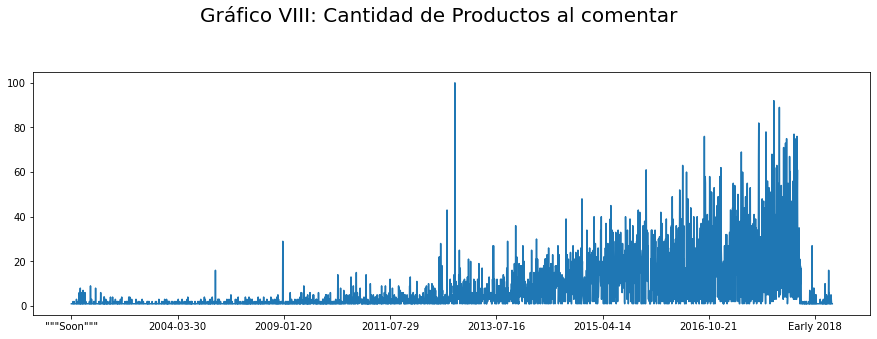

count   7733533.0
mean        235.4
std         483.7
min           1.0
25%          45.0
50%         110.0
75%         245.0
max       18188.0
Name: products, dtype: float64

In [18]:
#Boxplot Rooms
fig=plt.figure(figsize=(15,5))
plt.suptitle('Gráfico VIII: Cantidad de Productos al comentar',fontsize=20, ha='center')

games['release_date'].value_counts().sort_index().plot(kind='line', figsize=(15,5)) # ver layout#ax2.set_ylabel('Rooms',fontsize=16)
fig.subplots_adjust(top=0.8)
plt.show()

reviews.products.describe()

**Existe una tendencia a creciente a la publicación de juegos.**

### 5 - Breve exploración del contenido de cada juego.

In [19]:
genres=games['genres'].value_counts()
print(genres)

specs=games['specs'].value_counts()
print(specs)

tags=games['tags'].value_counts()
print(tags)

['Action']                                                           1880
['Action', 'Indie']                                                  1650
['Simulation']                                                       1396
['Casual', 'Simulation']                                             1359
['Action', 'Adventure', 'Indie']                                     1082
                                                                     ... 
['Action', 'Early Access', 'Free to Play', 'Strategy']                  1
['Adventure', 'Free to Play', 'Indie', 'Simulation']                    1
['Action', 'Indie', 'Racing', 'Simulation', 'Sports', 'Strategy']       1
['Free to Play', 'RPG', 'Simulation']                                   1
['Action', 'Adventure', 'Simulation', 'Strategy']                       1
Name: genres, Length: 883, dtype: int64
['Single-player']                                                                                                                                 

**Dado que el sistema de recomendación no es de contenido, esta variable no se trabajará en detalle.**

### 6 - Cómo son los comentarios sobre los juegos? 

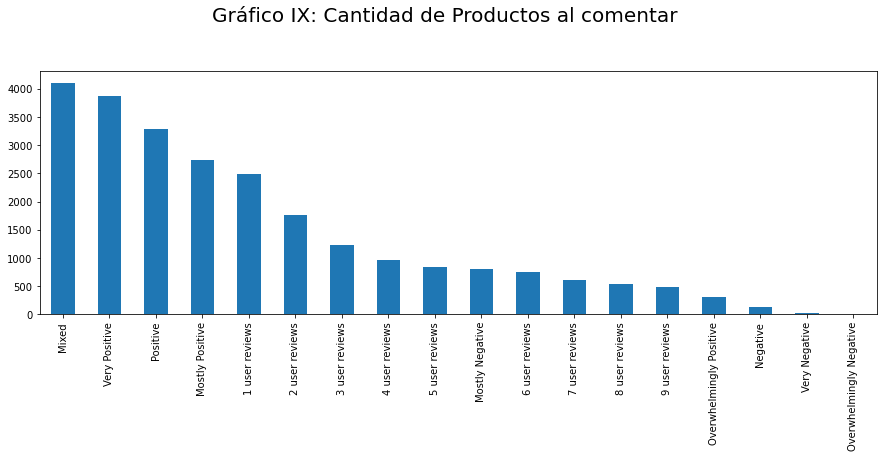

In [20]:
#Boxplot Rooms
fig=plt.figure(figsize=(15,5))
plt.suptitle('Gráfico IX: Cantidad de Productos al comentar',fontsize=20, ha='center')

valoraciones=games['sentiment'].value_counts().plot(kind='bar')
fig.subplots_adjust(top=0.8)
plt.show()

#by_metascore = games.sort_values('metascore',ascending=True)
#by_metascore.head(40)

Estas dos varibiables indicarían en términos generales las valoraciones de los juegos. Metascore tiene muchos valores faltantes, por lo qie será prioritaria sentiment.

## **Combinación de Datasets**: 

**Pregunta Interesante: ¿Existe una relación entre la valoración al comentar y la cantidad de horas jugadas?**

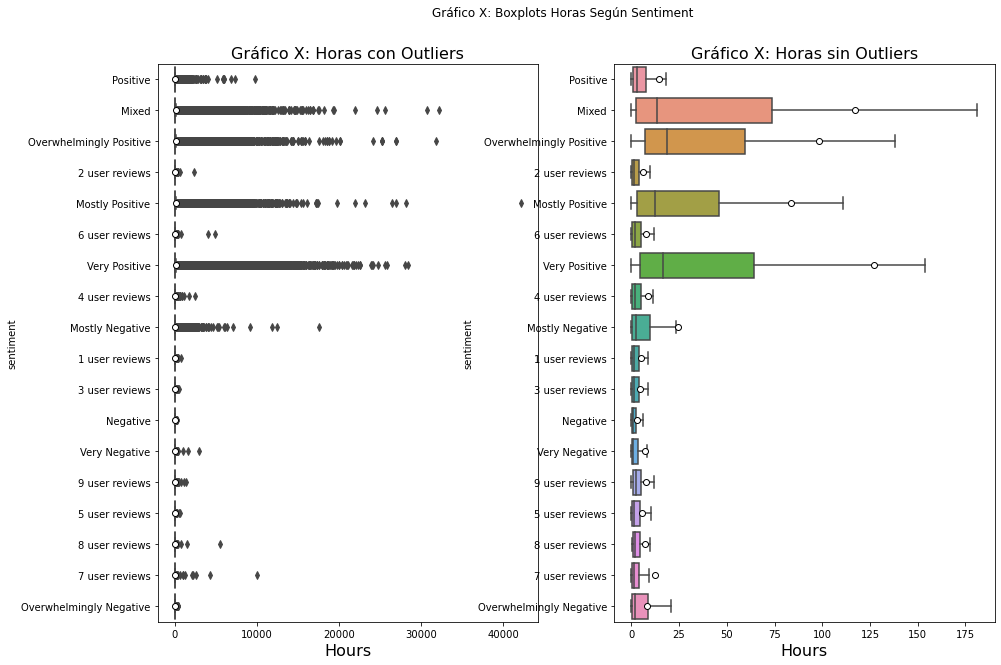

In [21]:
#reviews
reviews_2=reviews[['user_id','product_id','text','hours']]
reviews_2=reviews_2.reset_index(drop=True)

#se reaorganizan las columnas
games_2=games[['app_name','sentiment']]

comb=pd.merge(reviews_2,games_2, on='product_id')

grouped=comb.groupby('sentiment').mean().sort_values(('hours'),ascending=False)
#print(grouped)

#Boxplot Rooms
fig=plt.figure(figsize=(15,10))
plt.suptitle('Gráfico X: Boxplots Horas Según Sentiment', ha='center')
ax1=fig.add_subplot(1,2,1)
ax2=fig.add_subplot(1,2,2)
sns.boxplot(data = comb, x = "hours",y='sentiment',showfliers=True,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax1)

sns.boxplot(data = comb, x = "hours",y='sentiment',showfliers=False,showmeans=True,meanprops={"marker":"o","markerfacecolor":"white", "markeredgecolor":"black"}, ax=ax2)
ax1.set_title("Gráfico X: Horas con Outliers",fontsize=16)
ax2.set_title("Gráfico X: Horas sin Outliers",fontsize=16)
ax1.set_xlabel('Hours',fontsize=16)
#ax1.set_ylabel('',fontsize=16)
ax2.set_xlabel('Hours',fontsize=16)
#ax2.set_ylabel('Hours',fontsize=16)
fig.subplots_adjust(top=0.9)
plt.show()

No existen diferencias significativas en cuanto a la cantidad de horas jugadas para productos con valoraciones positivas y negativas, por lo que la variable sentiment no será considerada.
El sistema de recomendación se construirá considerando que a los usuarios les gustó un juego cuando jueguen a un determinado producto más que la mediana general que tienen al comentar. Sin embargo, pueden existir reviews positivos que se generen cuando los usuarios juegan menos que la mediana y visceversa (reviews negativos que se realicen a juegos con muchas horas de juego). Lo interesante sería poder analizar el primer caso para tratar de poder incorporarlos al sistema. Sin embargo, como se verá más adelante el dataset está muy desbalanceado, por lo que dicho segundo filtro no será incorporado al sistema de recomendación ya que querremos tomar solo los juegos con mayor cantidad de horas.
**Crearemos una nueva columna con la media de la cantidad de horas al realizar los comentarios. Si el valor de la columna horas es igual o mayor que est nuevo feature, consideraremos que el juego le gustó al usuario.**

In [22]:
#mapeo
grouped=comb.groupby('user_id').median().sort_values(('hours'),ascending=False).head(20)
#reorganizacion de columnas

#grouped=reviews.groupby('user_id').mean().sort_values(('price_m2'),ascending=False).head(20)
grouped
encod_type = comb.groupby('user_id')['hours'].median()
comb.loc[:, 'median_hours'] = comb['user_id'].map(encod_type)

comb.dropna(subset=['user_id'], how='all', inplace=True)
comb['implicit_rating'] = np.where(comb['hours']>=comb['median_hours'], 1, 0)
comb['implicit_rating'] = comb['implicit_rating'].astype(np.uint8)
#comb=comb[['user_id','implicit_rating','product_id']]
comb
comb = comb.reset_index(drop=True)
comb
#transformación de los tipos de datos
#reviews['hours'] = reviews['hours'].astype(np.float64)
comb['user_id'] = comb['user_id'].astype(np.int64)
comb['product_id'] = comb['product_id'].astype(np.uint32)
comb.dtypes
comb


,user_id,product_id,text,hours,app_name,sentiment,median_hours,implicit_rating
0,76561198159791792,725280,THE WORST GAME I HAVE EVER PLAYED!!! JUST DONT...,0.3,Psi Project,Positive,0.3,1
1,76561198060686752,328100,"A nice game, but better not to get started.\nT...",3.8,Gunspell - Steam Edition,Mixed,2.9,1
2,76561198011965360,328100,They do a fantastic job of matching proper gea...,1.3,Gunspell - Steam Edition,Mixed,4.8,0
3,76561198142240208,328100,Ok graphics and easy game to play. There is ma...,7.1,Gunspell - Steam Edition,Mixed,9.4,0
4,76561198031283776,328100,"Another nice try, but need better balance.",5.5,Gunspell - Steam Edition,Mixed,6.5,0
...,...,...,...,...,...,...,...,...
3156572,76561197970986928,518790,A completely unforgettable experience.,11.6,theHunter: Call of the Wild™,Mostly Positive,11.6,1
3156573,76561198191446304,518790,I would recommend this to any hunter loving fa...,1.3,theHunter: Call of the Wild™,Mostly Positive,59.2,0
3156574,76561198194088560,518790,It's freaking lit man. Have played quite a bit...,13.9,theHunter: Call of the Wild™,Mostly Positive,103.3,0
3156575,76561198071850352,518790,If you have a old computer i would not try thi...,0.2,theHunter: Call of the Wild™,Mostly Positive,0.2,1


# **B - Machine Learning**

14.5.1 Semejanza entre usuarios (User User)
Supongamos que queremos estimar las calificaciones que le faltan al usuario “i”.
Lo que hacemos es buscar los usuarios mas similares a “i” y luego estimar las
calificaciones faltantes en base a un promedio ponderado de las calificaciones
de los dem´as usuarios ponderadas de acuerdo a la semejanza que tengan con
nuestro usuario “i”.
Necesitamos entonces una funci´on de semejanza entre usuarios sim(u,v) que
calcule cu´an similares son dos usuarios en base a las calificaciones que han realizado los mismos. Cuanto m´as parecidas sean estas calificaciones m´as parecidos
ser´an los usuarios. Usuarios que han calificado conjuntos de ´ıtems disjuntos
tendr´an semejanza nula.
Una de las funciones m´as usadas para calcular la semejanza es la funci´on de
correlaci´on de Pearson:
sim(x, y) =
P
s∈Sxy
(rxs−rx)(rys−ry)
qP
s∈Sxy
(rxs−rx)
2
qP
s∈Sxy
(rys−ry)
2
(14.11)
Donde rx es el promedio de calificaciones del usuario x.
Notemos que si los promedios de calificaciones fueran cero entonces la funci´on
de correlaci´on de Pearson es el coseno entre x e y (dividido la productoria
de sus normas). En muchos casos se empieza entonces por centrar todas las
calificaciones de los usuarios en cero, es decir restarle a cada calificaci´on el
promedio del usuario.

In [23]:

#comenzamos borrando los valores nan de user id
encod_type = reviews.groupby('user_id')['hours'].median()
reviews.loc[:, 'median_hours'] = reviews['user_id'].map(encod_type)
reviews.dropna(subset=['user_id'], how='all', inplace=True)

reviews['implicit_rating'] = np.where(reviews['hours']>=reviews['median_hours'], 1, 0)
reviews['implicit_rating'] = reviews['implicit_rating'].astype(np.uint8)

reviews=reviews[['user_id','implicit_rating','product_id']]
reviews = reviews.reset_index(drop=True)
#transformación de los tipos de datos
#reviews['hours'] = reviews['hours'].astype(np.float64)
reviews['user_id'] = reviews['user_id'].astype(np.int64)
reviews['product_id'] = reviews['product_id'].astype(np.uint32)

games=games[['app_name']]

### Benchmark - SVD

In [24]:
reader = Reader(rating_scale = (0,1))

In [25]:
#creamos el DatasetSurprise
#N_filas=100000
data=Dataset.load_from_df(reviews[['user_id','product_id','implicit_rating']], reader)

In [26]:
trainset, testset = train_test_split(data, test_size=.25)

## Entrenamiento

In [27]:
#definimos
#La medida de similitud elegida es la que viene por defecto, es decir, similitud coseno.
from surprise import SVD
#sim_options = {'name': 'pearson','user_based': True  # compute  similarities between items}
algo = SVD()

In [28]:
#entrenamos
algo.fit(trainset)

In [29]:
#predecimos
predictions = algo.test(testset)

## Testeo

In [30]:
#vemos un ej. de predicción 
predictions[1]

Prediction(uid=76561198031697200, iid=306130, r_ui=1.0, est=0.8127652054122437, details={'was_impossible': False})

In [31]:
#estimamos para un usuario y un juego
#algo.predict(76561198011965359,440)
algo.predict(76561198011965360,440)

Prediction(uid=76561198011965360, iid=440, r_ui=None, est=0.8920496580018329, details={'was_impossible': False})

In [32]:
#películas que le gustaron a un usuario
usuario = 76561198023491408
rating = 1  

df_user = reviews[(reviews['user_id'] == usuario) & (reviews['implicit_rating'] == rating)]
df_user = df_user.reset_index(drop=True)
df_user['app_name'] = games['app_name'].loc[df_user.product_id].values
df_user

,user_id,implicit_rating,product_id,app_name
0,76561198023491408,1,337000,Deus Ex: Mankind Divided
1,76561198023491408,1,268050,The Evil Within
2,76561198023491408,1,238430,Contagion
3,76561198023491408,1,379720,DOOM
4,76561198023491408,1,9480,Saints Row 2
5,76561198023491408,1,222480,Resident Evil Revelations / Biohazard Revelations
6,76561198023491408,1,261640,Borderlands: The Pre-Sequel
7,76561198023491408,1,223470,POSTAL 2
8,76561198023491408,1,360430,Mafia III
9,76561198023491408,1,588430,Fallout Shelter


In [33]:
#películas que no le gustaron a un usuario
rating = 0  

df_user = reviews[(reviews['user_id'] == usuario) & (reviews['implicit_rating'] == rating)]
df_user = df_user.reset_index(drop=True)
df_user['app_name'] = games['app_name'].loc[df_user.product_id].values
df_user

,user_id,implicit_rating,product_id,app_name
0,76561198023491408,0,35140,Batman: Arkham Asylum Game of the Year Edition
1,76561198023491408,0,214250,I Am Alive
2,76561198023491408,0,20530,Red Faction
3,76561198023491408,0,238090,Sniper Elite 3
4,76561198023491408,0,20500,Red Faction Guerrilla Steam Edition
5,76561198023491408,0,20900,The Witcher: Enhanced Edition Director's Cut
6,76561198023491408,0,13210,Unreal Tournament 3 Black
7,76561198023491408,0,209160,Call of Duty®: Ghosts
8,76561198023491408,0,99300,Renegade Ops
9,76561198023491408,0,2610,GUN™


In [34]:
#cuáles vio?
usuario_vistas = reviews[reviews['user_id'] == usuario]
print(usuario_vistas.shape)
usuario_vistas

(110, 3)


,user_id,implicit_rating,product_id
3,76561198023491408,0,35140
6804,76561198023491408,1,337000
32290,76561198023491408,0,214250
88240,76561198023491408,0,20530
139341,76561198023491408,0,238090
...,...,...,...
2908948,76561198023491408,0,280
2918672,76561198023491408,0,12120
2942219,76561198023491408,0,209000
2973500,76561198023491408,1,234140


In [35]:
#acá guardamos las recomendaciones
recomendaciones_usuario=games.copy()

#borramos las vistas
recomendaciones_usuario.drop(usuario_vistas.product_id,inplace = True)
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario.shape
recomendaciones_usuario

,product_id,app_name
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,弹炸人2222
4,773570,Log Challenge
...,...,...
32019,773640,Colony On Mars
32020,733530,LOGistICAL: South Africa
32021,610660,Russian Roads
32022,658870,EXIT 2 - Directions


In [36]:
#recomendamos
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: algo.predict(usuario, x).est)
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
recomendaciones_usuario

,product_id,app_name,Estimate_Score
23274,377530,侠客风云传(Tale of Wuxia),0.9
28983,237970,Memento Mori 2,0.9
14646,658160,ClickRaid,0.9
11281,673190,All-Star Fruit Racing,0.9
25125,251290,The Legend of Heroes: Trails in the Sky SC,0.8
...,...,...,...
11342,643870,Kitten adventures in city park,0.0
26670,355970,Home is Where One Starts...,0.0
2669,302690,Metal Dead,0.0
26995,346040,Joe's Diner,0.0


## Evaluación

Utilizaremos el rmse. La principal crítica a esta métrica es que ciertos
errores no son tan importantes como otros ya que cometer errores
con los juegos que más le gustaron al usuario es mas grave que cometer errores
sobre los juegos que no le han gustado o con calificaciones intermedias.

In [37]:
from surprise import accuracy
accuracy.rmse(predictions)

RMSE: 0.4362


0.4362288253387486

## Optimizacón de parámetros

In [38]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4,8,10,12]

for factor in factores:
    print(f'\nNúmero de Factores: {factor}')
    algo = SVD(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))


Número de Factores: 1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4332  0.4328  0.4335  0.4332  0.0003  
Fit time          35.70   38.23   37.80   37.25   1.10    
Test time         9.23    9.79    9.14    9.39    0.29    

Número de Factores: 2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4332  0.4327  0.4333  0.4331  0.0003  
Fit time          38.62   39.46   41.32   39.80   1.13    
Test time         9.53    10.44   9.60    9.86    0.42    

Número de Factores: 4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4336  0.4331  0.4327  0.4331  0.0004  
Fit time          40.14   40.04   35.92   38.70   1.97    
Test time         9.80    8.06    8.05    8.64    0.82    

Número de Factores: 8
Evaluating RMSE of algorithm SVD on 3 split(s).

    

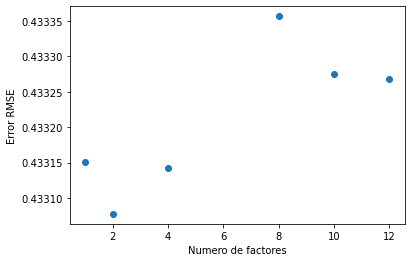

In [39]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

Parámetros a optimizar:

- n_factors : el número de factores.

- n_epochs : el número de iteraciones del descenso por gradiente estocástico.

- lr_all : la tasa de aprendizaje de todos los parámetros.

- reg_all : término de regularización para todos los parámetros. 

In [40]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [2],'n_epochs': [10], 'lr_all': [0.005],
              'reg_all': [0.01]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'],cv=2, n_jobs = -1)
gs.fit(data)

In [41]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.4284650082270388
{'n_factors': 2, 'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.01}


## SVD++

In [42]:
#definimos
from surprise import SVDpp
algo = SVDpp()

In [43]:
algo.fit(trainset)

In [44]:
#predecimos
predictions = algo.test(testset)

In [45]:
#vemos un ej. de predicción 
predictions[1]

Prediction(uid=76561198031697200, iid=306130, r_ui=1.0, est=0.7558318479049856, details={'was_impossible': False})

In [46]:
from surprise import accuracy
accuracy.rmse(predictions)


RMSE: 0.4155


0.41554778107519186

In [47]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [4]

for factor in factores:
    print(f'\nNúmero de Factores: {factor}')
    algo = SVDpp(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))


Número de Factores: 1
Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4190  0.4221  0.4181  0.4197  0.0017  
Fit time          208.05  224.36  233.92  222.11  10.68   
Test time         17.35   20.27   21.03   19.55   1.59    

Número de Factores: 2
Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4187  0.4202  0.4187  0.4192  0.0007  
Fit time          218.71  223.97  223.02  221.90  2.29    
Test time         17.55   17.41   20.40   18.45   1.38    

Número de Factores: 4
Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.4176  0.4174  0.4189  0.4180  0.0007  
Fit time          238.71  259.44  261.15  253.10  10.20   
Test time         19.79   20.29   19.38   19.82   0.37    


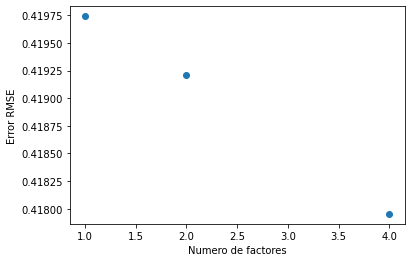

In [48]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

In [ ]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [4],'n_epochs': [20], 'lr_all': [0.005],
              'reg_all': [0.01]}

gs = GridSearchCV(SVDpp, param_grid, measures=['rmse'],cv=2, n_jobs = -1)
gs.fit(data)
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

**A partir de correr los dos modelos y optimizar hiperparámetros, se elije como mejor modelo a SVD++ porque minimiza el RMSE en el valor 0.4122830997858415.
Los hiperparámetros seleccionados son:

- n_factors': 4, 

- n_epochs': 20

- lr_all': 0.005, 

- reg_all: 0.01

#  **C - Investigación**

**Algunas sugerencias para continuar con el modelo son las siguientes:**

1 - Utilizar procesamiento del lenguaje natural para poder interpretar el texto de cada review. Con el uso de librerías vistas en clase como NLTK se podría alcanzar una mejor interpretación de la columna "text" del dataset "Reviews".

2 - Otra oportunidad de mejora sería establecer una métrica superadora al rmse ya que en en las preferencias reales, algunos errores no son tan importantes como otros, por ejemplo si un usuario utilizó durante muchas horas un juego y el sistema predice que no le gusta tenemos un error igual a 1, que es el mismo error que existe entre un juego que no le gusta y que el sistema recomienda. Sin embargo el primero es bastante mas importante que el segundo ya que a la hora de recomendar
queremos encontrar los juegos que le gustan. 

3 - Otra posibilidad de mejora sería estudiar modificaciones que permitan garantizar el cumplimiento de la serendipity: podrían eliminarse las recomendaciones obvias, por ejemplo, quitando de recomendaciones_usuario los juegos más populares. 

4 - Finalmente, también se podría desarrollar un algoritmo que nos permita recomendar
ítems nuevos. Algunos de estos ítems van a ser buenos y otros no, incluso pueden ser muy malos. Tenemos que
descubrir cuáles serán realmente buenos mediante experimentación. Los algoritmos que se
encargan de este tipo de cuestiones se denominan ”multi-armed bandits”


**Con las mejoras planteadas se espera encontrar los mejores resultados:**

1 - Con esto se espera poder verificar la hipotesis planteada tras realizar la "pregunta interesante": se graficaron boxplots que expresan la distribución de horas según el tipo de comentarios de cada juego y se verificó que no hay una relación directa entre el tiempo jugado al realizar el review y las valoraciones indicadas en el dataset "games" (según este análisis, por ejemplo, los juegos con comentarios Mixtos tienen una media y una mediana mayor de horas de juegos que los aquellos con reviews mayoritariamente positivos) lo cual no sería muy lógico a priori aunque podría suceder, por ejemplo, que usuarios comenten negativamente juegos que les gustan solo por el hecho de querer realizar "críticas objetivas", por estar influenciados por otros comentarios o simplemente por cansarse de los juegos tras jugarlos muchas horas (por cambio de gustos, por frustración al no poder ganarlo, por no tener un buen final, etc).

2 - Con estas métricas basadas en el orden se espera poder mejorar el ranking al otorgar mayor relevancia al error de las primeras posiciones del ranking de recomendaciones de cada usuario.En definitiva cometer errores con los juegos que mas le gustaron al usuario es mas grave que cometer errores sobre los juegos que no le han gustado o con calificaciones intermedias.  MPR (Mean Reciprocal Rank) y MAP (Mean Average Precision) son métricas basadas en el orden que intentan atacar este problema.

3 - Esta implementación quitaría los juegos más conocidos como Team Fortress 2, Rust y Bordenlands 2 (el top tres con mayores recomendaciones).

4 - Podría incluirse una sección de recomendaciones llamada "novedades" para poder calificar a los juegos nuevos y combatir el problema del cold start.

 ## **D - Análisis Exploratorio utilizando NLP**

**Esta punto pretende explorar el tipo de comentarios y se fundamenta en el hecho de que el sistema de recomendación del Tp3 consideraba como juegos recomendados aquellos que fueron comentados por usuarios que realizaron su review al superar su propia mediana global de horas de juegos. Sin embargo, al realizar esta diferenciación, se corre el riesgo de cometer dos tipos de errores: incorporar juegos con comentarios positivos con pocas horas de juego y juegos con comentarios negativos con muchas horas de juego.**
**Como se vió anteriormente, existe una gran similitud entre los juegos comentados negativamente y positivamente en cuanto a la cantidad de horas jugadas.Para realizar la exploración se tratará de tomar los comentarios negativos a partir de las categorías provistas por el dataset games y extrapolarlas al dataset games a fin de saber cuáles son las palabras más frecuentes en cada uno de ellos.**

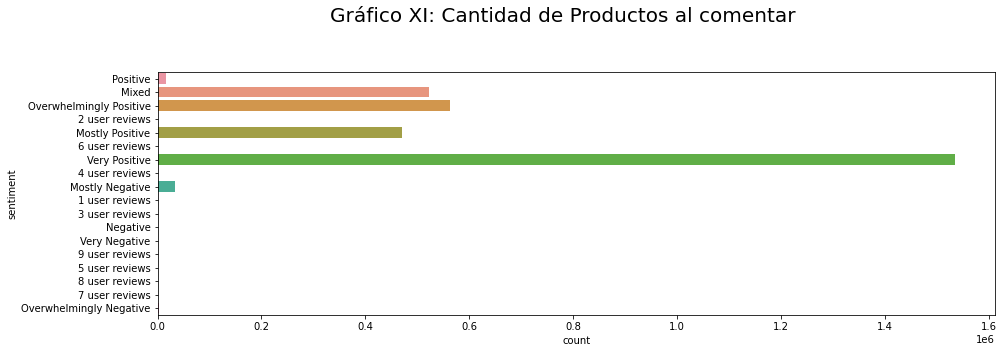

In [50]:
nlp_dataset=comb
fig=plt.figure(figsize=(15,5))
plt.suptitle('Gráfico XI: Cantidad de Productos al comentar',fontsize=20, ha='center')
sns.countplot(y=nlp_dataset.sentiment)
fig.subplots_adjust(top=0.8)
plt.show()

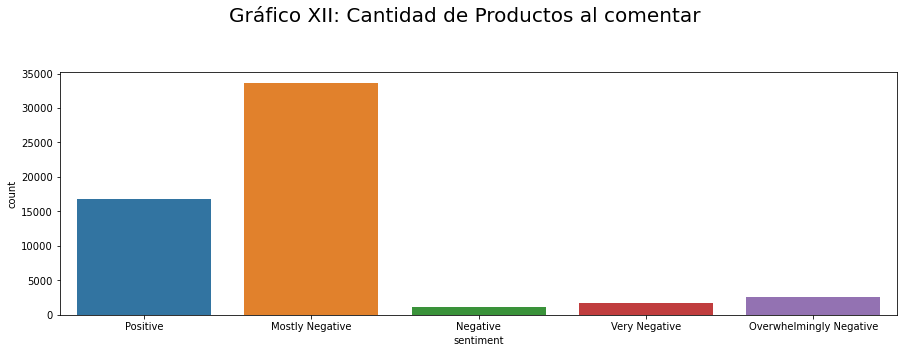

53183 First of all, I cannot believe that STEAM is still selling this unmitigated piece of crap.
I'm not sure if the developer *ever* actually intended to complete the game, or if this was a simple cash grab right from the start. Either way, my suggestion would be to run, don't walk, as far away from this... I can't even call it a game, as I've never actually ever even gotten it to start up for me.
Anyway, you get the picture. If you choose to pick this up anyway, on your own head be it. You have been warned... Mostly Negative


In [51]:
#nlp_dataset=new_dataset[['text','sentiment']]
nlp_dataset=nlp_dataset[(nlp_dataset.sentiment=='Positive')|
                        (nlp_dataset.sentiment=='Overwhelmingly Negative')|
                        (nlp_dataset.sentiment=='Very Negative')|
                        (nlp_dataset.sentiment=='Mostly Negative')|
                        (nlp_dataset.sentiment=='Negative')]

fig=plt.figure(figsize=(15,5))
plt.suptitle('Gráfico XII: Cantidad de Productos al comentar',fontsize=20, ha='center')
sns.countplot(nlp_dataset.sentiment)
fig.subplots_adjust(top=0.8)
plt.show()


#breve exploración a través de un ejemplo aleatorio
index_random = np.random.randint(0,high = nlp_dataset.shape[0])
texto = nlp_dataset.iloc[index_random].text
print(index_random, texto, nlp_dataset.iloc[index_random].sentiment)

**Hasta aquí, se vió que el dataset está muy desbalanceado y que el porcentaje de reviews negativos es ínfimo, por lo que se descarta el uso del atributo text para la mejora del sistema de recomendación. De todas formas, se realizará el análisis exploratorio para poder diferenciar binariamente entre reviews positivos y negativos.**

**Tokenización, StopWords y Rarewords**

In [52]:
#nlp_dataset
filtrar = []
if True:
    filtrar.append("game")
    filtrar.append("I")
    filtrar.append("The")
    filtrar.append("It")
    filtrar.append("This")
    filtrar.append("one")
    filtrar.append("not")
    filtrar.append("get")
    filtrar.append("really")
    filtrar.append("games")
    filtrar.append("like")
    filtrar.append("play")
    filtrar.append("time")
    filtrar.append("would")
    filtrar.append("even")
    filtrar.append("good")
    filtrar.append("much")
    filtrar.append("You")
    filtrar.append("first")
    filtrar.append("make")
    filtrar.append("playing")
    filtrar.append("If")
    filtrar.append("played")
    filtrar.append("A")
    filtrar.append("There")

#TOKENIZACIÓN CON NLTK
titular_st = nltk.tokenize.sent_tokenize(texto)
titular_wt = nltk.tokenize.word_tokenize(texto)
    
#NORMALIZACIÓN 
stopwords = nltk.corpus.stopwords.words('english')
stopwords = [palabra for palabra in stopwords if 'not' not in palabra]

titular_wt_sin_sw = [word for word in titular_wt if word not in stopwords]

#FRECUENCIA DE PALABRAS
freq=nltk.FreqDist(titular_wt_sin_sw)

### Textos Positivos

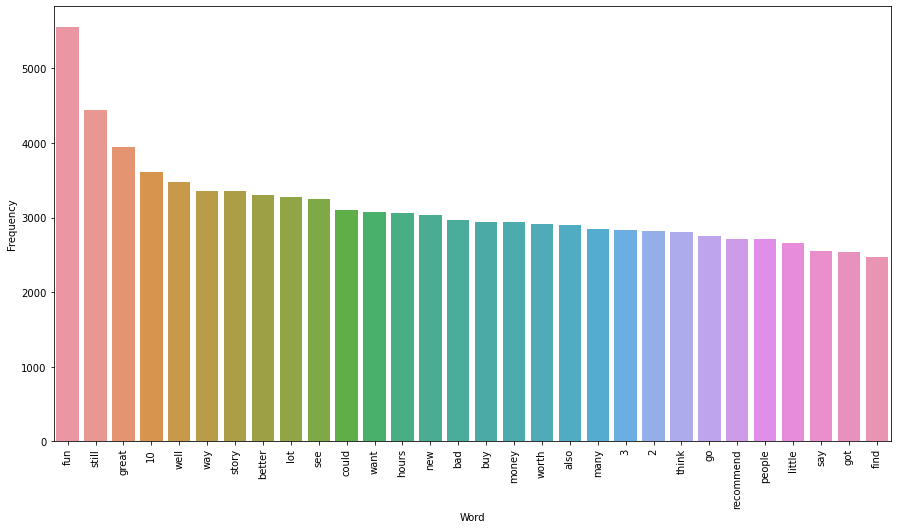

In [53]:
# Agrupar los titulares por tipo. Crear un dataframe para cada uno. Recuerden usar máscaras.
dataset_positive = nlp_dataset[nlp_dataset.implicit_rating==1]

#toquenización+borrado de stopwords, palabras de filtrar y palabras de menos de tres letras
todos_textos_positivos = []
for i in range(dataset_positive.shape[0]):
    texto = dataset_positive.iloc[i].text
    texto = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(texto)
    texto = [word for word in texto if word not in stopwords]
    texto = [word for word in texto if word not in filtrar]
    textoi= [word for word in texto if len(word)>3]

    todos_textos_positivos.append(texto)
    
todos_textos_positivos = list(itertools.chain(*todos_textos_positivos))
#todos_textos_positivos[0:10]
freq_textos_positivos = nltk.FreqDist(todos_textos_positivos)


df_positivos = pd.DataFrame(list(freq_textos_positivos.items()), columns = ["Word","Frequency"])
df_positivos.sort_values('Frequency',ascending=False, inplace = True)
df_positivos.reset_index(drop = True, inplace=True)
df_positivos.head()

plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_positivos.iloc[:30].Word, y = df_positivos.iloc[:30].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

### Textos Negativos

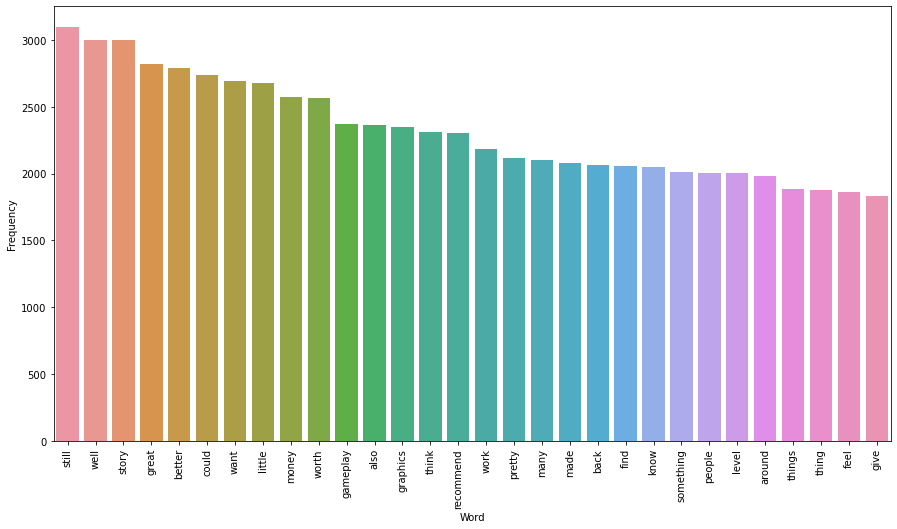

In [54]:
dataset_negative = nlp_dataset[nlp_dataset.implicit_rating==0]

todos_textos_negativos = []
for i in range(dataset_negative.shape[0]):
    texto = dataset_negative.iloc[i].text
    texto = nltk.tokenize.RegexpTokenizer("[\w]+").tokenize(texto)
    texto = [word for word in texto if word not in stopwords]
    texto = [word for word in texto if word not in filtrar]
    texto= [word for word in texto if len(word)>3]
    todos_textos_negativos.append(texto)
    
todos_textos_negativos = list(itertools.chain(*todos_textos_negativos))

freq_negative = nltk.FreqDist(todos_textos_negativos)

df_negative = pd.DataFrame(list(freq_negative.items()), columns = ["Word","Frequency"])

df_negative.sort_values('Frequency',ascending=False, inplace = True)

df_negative.reset_index(drop = True, inplace=True)

plt.figure(figsize = ( 15,8))
plot = sns.barplot(x  = df_negative.iloc[:30].Word, y = df_negative.iloc[:30].Frequency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

**Lematización**

In [55]:
#dataset=comb
dataset= pd.concat([dataset_positive, dataset_negative])
dataset=pd.concat([dataset.text,dataset.implicit_rating],axis=1)
dataset.dropna(axis=0,inplace=True)  # Si hay alguna nan, tiramos esa instancia
dataset.head()

# Importamos esta libreria que nos permite reemplzar caracteres
import re

# Importamos el lemmatizar de NLTK, y creamos el objeto
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [56]:
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


In [57]:
# Importamos el lemmatizar de NLTK, y creamos el objeto
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

# Importamos esta libreria que nos permite reemplzar caracteres
import re

# Traemos nuevamente las stopwords
stopwords = nltk.corpus.stopwords.words('english')
#stopword.remove('no')
#stopword.remove('not')

In [58]:
titular_list=[]
for titular in dataset.text:
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    titular=re.sub("[^a-zA-Z]"," ",str(titular))
    # Pasamos todo a minúsculas
    titular=titular.lower()
    # Tokenizamos para separar las palabras
    titular=nltk.word_tokenize(titular)
    # Aplicamos el Lemmatizer (Esto puede tardar un ratito)
    frase_lemma = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in titular]
    # Eliminamos las palabras demenos de 3 letras
    titular = [palabra for palabra in titular if len(palabra)>3]
    # Sacamos las Stopwords
    titular = [palabra for palabra in titular if not palabra in stopwords]
    # Por ultimo volvemos a unir el titular
    titular=" ".join(titular)
    #dataset["titular_normalizado"] = titular_list
    titular_list.append(titular)

In [59]:
dataset["titular_lemm"] = titular_list
dataset_lemm = pd.concat([dataset.titular_lemm,dataset.implicit_rating],axis=1)
dataset_lemm.dropna(axis=0,inplace=True)  # Por si quedaron titulares vacios
dataset_lemm.head()

,titular_lemm,implicit_rating
0,worst game ever played dont give money,1
4899,somewhere zibylon zibylon command centre read ...,1
5784,afraid afraid well certainly links master horr...,1
5786,game good annoys steam stopped update game stu...,1
5788,hard game recommend people actually liked anim...,1


In [60]:
# Tomamso la lista de palabras y el vector que nos dice si es o no sarcastico el titulo
list_titulos = list(dataset_lemm['titular_lemm'].values)
recomendado = dataset_lemm['implicit_rating'].values

## Para probar con Stemmizer:
#list_titulos = list(dataset_stem'titular_stem'].values)
#is_sarc = dataset_stem['is_sarcastic'].values

from sklearn.feature_extraction.text import CountVectorizer

# Usaremos solo las 1000 palabras con mas frecuencia en todo el corpus para generar los vectores
max_features=1000

# Es decir que cada instancia tendrá 1000 features
cou_vec=CountVectorizer(max_features=max_features) # stop_words="english" , ngram_range=(1, 2)

matriz_titulos = cou_vec.fit_transform(list_titulos)

# Tomamos las palabras
all_words = cou_vec.get_feature_names()

# Vizualizamos las 50 palabras mas usadas
print("50 palabras mas usadas: ",all_words[0:50])

50 palabras mas usadas:  ['abandoned', 'abilities', 'ability', 'able', 'absolute', 'absolutely', 'access', 'achievements', 'across', 'acting', 'action', 'actual', 'actually', 'added', 'addictive', 'adding', 'addition', 'adds', 'adventure', 'allow', 'allows', 'almost', 'alone', 'along', 'alot', 'alpha', 'already', 'also', 'although', 'always', 'amazing', 'amount', 'animation', 'animations', 'annoying', 'another', 'anymore', 'anyone', 'anything', 'anyway', 'apparently', 'appear', 'appears', 'arcade', 'area', 'areas', 'around', 'aside', 'asking', 'aspect']


acc :  0.5410805483379626


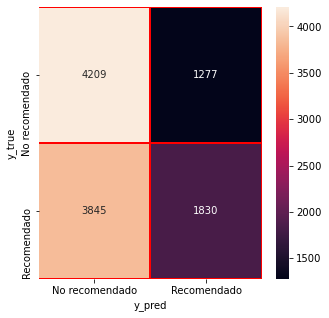

In [61]:
x = matriz_titulos.toarray()
y = recomendado

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)


from sklearn.metrics import confusion_matrix

def confusion(ytest,y_pred):
    names=["No recomendado","Recomendado"]
    cm=confusion_matrix(ytest,y_pred)
    f,ax=plt.subplots(figsize=(5,5))
    sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
    plt.xlabel("y_pred")
    plt.ylabel("y_true")
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

    return


from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(xtrain,ytrain)
print("acc : ", nb.score(xtest,ytest))


y_pred=nb.predict(xtest)
confusion(ytest,y_pred)

acc:  0.574679688199982


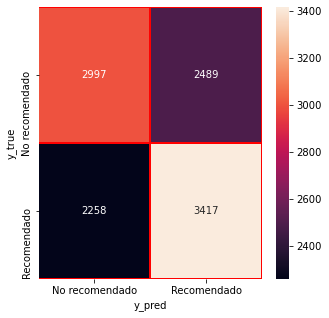

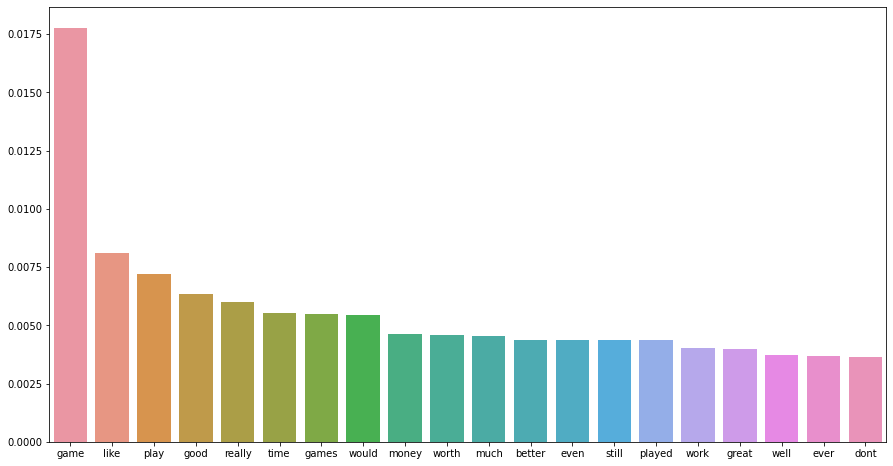

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators = 100, random_state=42)
rf.fit(xtrain,ytrain)
print("acc: ",rf.score(xtest,ytest))


y_pred=rf.predict(xtest)
confusion(ytest,y_pred)


# Le preguntamos la importancia de cada feature (cada palabra)
importances = rf.feature_importances_
# Tomamos la lista de palabras
all_words = cou_vec.get_feature_names()
columns = all_words

# Ordenamos por importnacia y tomamos las 20 primeras
indices = np.argsort(importances)[::-1]
indices = indices[:20]
selected_columns = [columns[i] for i in indices]
selected_importances = importances[indices]

# Por ultimo graficamos
plt.figure(figsize = (15,8))
sns.barplot(selected_columns, selected_importances)
plt.show()

#### Conclusión NLP:

**Este punto trató de incorporar los juegos con comentarios positivos pero con poco tiempo de juego al sistema de recomendación, sin embargo, tras realizar el análisis se concluye que no es factible realizar mejoras sustanciales en el sistema de recomendación incorportando NLP por las siguientes razones:**
    - a pesar de que no se cuenta con un feautre que defina a cada review como positivo o negativo, se cuenta con una aproximación a través de la columna "sentiment" del dataset games, Sin embargo, existe un fuerte desbalance que dificulta caracterizar a los reviews negativos por ser una pequeña minoría del dataset total.
    - las categorías de juegos con comentarios negativos tienen muchas palabras en común con las categorías con comentarios positivos.
    - los accuracy de los modelos entrenados fueron bajos (acc: 0,54 para random forest)
    
    Por estas razón, se recomienda continuar trabajando con el modelo presentado en el Trabajo Nro.